In [1]:
from IPython.core.display import display, HTML
# Full display of notebook (width of screen)
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import basic libraries
import os, glob, sys
import numpy as np   
import pandas as pd 

# Define librearies needed for analysis
import matplotlib.pyplot as plt # Matplotlibrary
import seaborn as sns # Seaborn Library

# Plotting pretty figures
import itertools
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size']       = 19
plt.rcParams['figure.figsize']  = (12.0, 7.0)
plt.rcParams['lines.linewidth'] = 2

SMALL_SIZE = 19
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font',  size = SMALL_SIZE)
plt.rc('axes',  titlesize = MEDIUM_SIZE)
plt.rc('xtick', labelsize = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('axes',  linewidth = 2)

params = {
            'xtick.major.width': 2.15,
            'xtick.minor.width': 1.25,
            'xtick.major.size': 8,
            'xtick.minor.size': 3.5,
            'ytick.major.width': 2.15,
            'ytick.minor.width': 1.25,
            'ytick.major.size': 8,
            'ytick.minor.size': 3.5
         }

plt.rcParams.update(params)

feat_path = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))))
if feat_path not in sys.path:
    sys.path.append(feat_path)
    
%load_ext autoreload
%autoreload 2

np.random.seed(42)

# get additional tools
from src.utils import utils 
from src.train import pipeline
from src.test import predict

# Define path where data is located and folder to access to it
path_data = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))),'data','external')

# 1. Data pre-processing

In [2]:
# load data in pd dataframe
train, test = utils.load_data(path_data)
# Fill test data by defaut value
test['Survived'] = 666

data = pd.concat([train,test])

In [4]:
# Apply all data transformations from EDA
data = pipeline.transformation_features(data)
data = utils.drop_features(data, ['Ticket', 'Cabin' ,'Name'])
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title,Deck,Has_Cabin,Type_Ticket,Words_Count
0,1,0,3,male,B,1,0,A,S,B,Mr,None,No,139,4
1,2,1,1,female,C,1,0,D,C,B,Mrs,C,Yes,154,7
2,3,1,3,female,B,0,0,B,S,A,Miss,None,No,165,3
3,4,1,1,female,C,1,0,D,S,B,Mrs,C,Yes,3,7
4,5,0,3,male,C,0,0,B,S,A,Mr,None,No,108,4


In [5]:
# Define features to transform
other_features   = ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Type_Ticket', 'Words_Count']
cat_ord_features = ['Deck', 'Has_Cabin']
cat_hot_features = ['Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'Title']

In [6]:
data = pipeline.pipeline_features(data, cat_ord_features, cat_hot_features, other_features)
data.head()

,Deck,Has_Cabin,Sex_female,Sex_male,Age_A,Age_B,Age_C,Age_D,Age_E,Fare_A,...,Title_Mr,Title_Mrs,Title_Rare,PassengerId,Survived,Pclass,SibSp,Parch,Type_Ticket,Words_Count
0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,139.0,4.0
1,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,154.0,7.0
2,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,165.0,3.0
3,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4.0,1.0,1.0,1.0,0.0,3.0,7.0
4,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,108.0,4.0


In [7]:
Y_train = data['Survived'][:len(train)]

X_train_data = data.drop(other_features[:2], axis=1)[:len(train)]
X_test  = data[len(train):]

X_train_data.shape, X_test.shape, Y_train.shape

((891, 29), (418, 31), (891,))

# 2. Result without tunning

In [8]:
# ML models
from sklearn.tree import DecisionTreeClassifier # Generic Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC # Support Vector machine
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Calculate Baseline
rfc = RandomForestClassifier(n_estimators=500, random_state=24, n_jobs = -1)
dtc = DecisionTreeClassifier(random_state=24)
xgbo = XGBClassifier(random_state=24, n_jobs = -1)
lgbw = LGBMClassifier(learning_rate = 0.05, n_jobs=-1)
sgd = SGDClassifier(loss=  "log", random_state=24, n_jobs = -1)
svc = SVC(probability=True, random_state=24)
lrc = LogisticRegression(random_state=24, n_jobs = -1)
knc = KNeighborsClassifier(n_jobs = -1)

# Models
clfs = {
        'SGD'     : sgd,
        'LR'      : lrc,
        'DT'      : dtc,
        'RF'      : rfc,
        'KN'      : knc,
        'lgb'     : lgbw,
        'XGB'     : xgbo, 
        }

for name, model in clfs.items():
    
    print("Classifier: {}".format(name))
    results  = cross_val_score(model, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
    print(r"Accuracy : ({:.2f} +- {:.2f})%".format(  results.mean() * 100, results.std() * 100))
    
    #model.fit(X_train_data, Y_train)
    #score = round(model.score(X_train_data, Y_train) * 100, 2)
    #print(r"model confidence score :{:.2f}%".format(score))
    print("")

Classifier: SGD
Accuracy : (64.00 +- 19.17)%

Classifier: LR
Accuracy : (82.04 +- 2.74)%

Classifier: DT
Accuracy : (78.12 +- 3.54)%

Classifier: RF
Accuracy : (79.80 +- 3.09)%

Classifier: KN
Accuracy : (77.11 +- 2.68)%

Classifier: lgb
Accuracy : (84.06 +- 3.27)%

Classifier: XGB
Accuracy : (81.71 +- 2.83)%



In [9]:
# Make predictions of a specific model
model_name = 'lgb'
submission = predict.make_prediction(clfs[model_name], X_train_data, Y_train, X_test) 

# Save predictions in desired format
submission.to_csv('submission_{}.csv'.format(model_name), index=False)

In [ ]:
#pip list

# 3. Result without tunnin (with features selection)

In [10]:
from src.features.feature_selector import FeatureSelector

# New features selection for transformed data
train_labels = Y_train
train_ = X_train_data

fs = FeatureSelector(data = train_, labels = train_labels)

In [11]:
fs.identify_single_unique()

0 features with a single unique value.



In [12]:
fs.identify_collinear(correlation_threshold=0.95)

1 features with a correlation magnitude greater than 0.95.



In [13]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features
collinear_features

['Sex_male']

In [14]:
# Collinear plot of all maximally correlated features
#fs.identify_collinear(correlation_threshold=0.96)
#fs.plot_collinear()

In [15]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'multi_logloss', 
                            n_iterations = 10, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.390159
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.282612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.416281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.339698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.383915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.359533
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.316139
Train

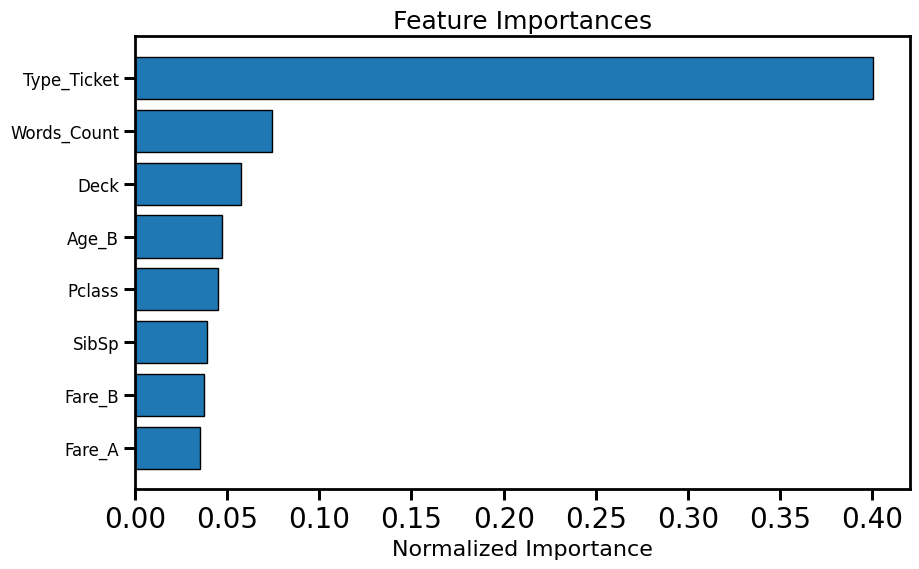

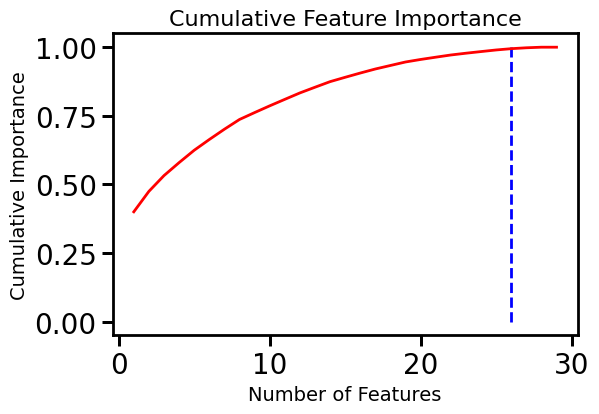

26 features required for 0.99 of cumulative importance


In [16]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 8)

In [17]:
# gather all identified features for for removal
remove = fs.check_removal()

Total of 2 features identified for removal


In [18]:
# Remove features suggested for Training and Testing data
X_train_data = X_train_data.drop(np.intersect1d(remove, X_train_data.keys()), axis=1)
X_test       = X_test.drop(np.intersect1d(remove, X_test.keys()), axis=1)

In [19]:
X_test  = data[len(train):]
X_test = X_test.drop(other_features[:2], axis=1)
X_test

,Deck,Has_Cabin,Sex_female,Sex_male,Age_A,Age_B,Age_C,Age_D,Age_E,Fare_A,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Pclass,SibSp,Parch,Type_Ticket,Words_Count
891,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,81.0,3.0
892,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,98.0,5.0
893,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,45.0,4.0
894,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,77.0,3.0
895,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,74.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,137.0,3.0
1305,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,154.0,5.0
1306,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,164.0,4.0
1307,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,96.0,3.0


In [20]:
for name, model in clfs.items():
    
    print("Classifier: {}".format(name))
    
    # compute benchmark
    results  = cross_val_score(model, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
    
    print(r"Acc : ({:.2f} +- {:.2f})%".format(  results.mean() * 100, results.std() * 100))
    print("")

Classifier: SGD
Acc : (66.99 +- 14.07)%
F1_w: (61.92 +- 18.88)%

Classifier: LR
Acc : (81.93 +- 2.84)%
F1_w: (81.85 +- 2.89)%

Classifier: DT
Acc : (76.99 +- 3.86)%
F1_w: (76.99 +- 3.97)%

Classifier: RF
Acc : (80.14 +- 3.09)%
F1_w: (80.00 +- 3.19)%

Classifier: KN
Acc : (76.43 +- 2.49)%
F1_w: (75.34 +- 2.68)%

Classifier: lgb
Acc : (84.06 +- 3.27)%
F1_w: (83.86 +- 3.38)%

Classifier: XGB
Acc : (81.82 +- 2.74)%
F1_w: (81.68 +- 2.88)%



In [ ]:
# Make predictions of a specific model
mod_name = 'lgb'
submission = predict.make_prediction(clfs[mod_name], X_train_data, Y_train, X_test) 

# Save predictions in desired format
submission.to_csv('submission_{}.csv'.format(mod_name), index=False)

# 4. Ensemble without tunning

In [24]:
from sklearn.ensemble import VotingClassifier

named_estimators = [ 
                     ('LR', dtc),
                     ('RF', rfc),
                     ('lgb' , lgbw),
                     ('XGB' , xgbo)
                    ]

voting_clf = VotingClassifier(named_estimators,voting='hard')
voting_clf.fit(X_train_data, Y_train)

results  = cross_val_score(voting_clf, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')

print(r"Accuracy combined ensemble: ({:.2f} +- {:.2f})%".format(  results.mean() * 100, results.std() * 100))
print("")

Acc combined ensemble: (82.50 +- 3.35)%



# 5. Optimization

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

space = {
            'max_depth': hp.choice('max_depth', [5, 10, 15, 20, 25,  30, None]),
            'learning_rate':hp.choice('learning_rate', [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]),
            'subsample':hp.choice('subsample', [0.1, 0.4, 0.7, 0.9, 1.0]),
            'colsample_bytree':hp.choice('colsample_bytree', [0.1, 0.3, 0.6, 1.0]),
            'colsample_bylevel':hp.choice('colsample_bylevel', [0.1, 0.4, 0.5, 1.0]),
            'min_child_weight':  hp.choice('min_child_weight', [0.5, 1.0, 5.0, 10]),
            'gamma':hp.choice('gamma', [0, 0.25, 0.5, 1.0]),
            'n_estimators': hp.choice('n_estimators', [25, 50, 100, 150, 200, 250, 350, 500, 750, 1000, 1250])
          }  

def objective(space):

    model = LGBMClassifier(  n_estimators = space['n_estimators'],
                            max_depth = space['max_depth'],
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            colsample_bylevel = space['colsample_bylevel'],
                            random_state=24  
                            )
    
    metric = cross_val_score(model, X_train_data, Y_train, cv = 5, 
                             scoring = 'accuracy',
                             n_jobs= -1).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -metric, 'status': STATUS_OK } 

In [ ]:
# Evaluate
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 35,
            trials= trials)

In [ ]:
# define keys representing best results from space probed
max_dep  = {0: 5, 1: 10, 2: 15, 3: 20, 4: 25, 5: 30, 6: None}
lr       = {0: 0.01, 1: 0.05, 2: 0.1, 3: 0.2, 4: 0.3, 5: 0.5}
sub      = {0: 0.1, 1: 0.4, 2: 0.7, 3: 0.9, 4: 1}
coltree  = {0: 0.1, 1: 0.3, 2: 0.6, 3: 1}
colby    = {0: 0.1, 1: 0.4, 2: 0.5, 3: 1}
minchil  = {0: 0.5, 1: 1, 2: 5, 3: 10}
gam      = {0: 0, 1: 0.25, 2: 0.5, 3: 1}
est      = {0: 25, 1: 50, 2: 100, 3: 150, 4: 200, 5: 250, 6: 350, 7: 500, 8: 750, 9: 1000, 10: 1250}

# train final model from best parameters found
model = LGBMClassifier( n_estimators = est[best['n_estimators']],
                        max_depth = max_dep[best['max_depth']],
                        learning_rate = lr[best['learning_rate']],
                        gamma = gam[best['gamma']],
                        min_child_weight = minchil[best['min_child_weight']],
                        subsample = sub[best['subsample']],
                        colsample_bytree = coltree[best['colsample_bytree']],
                        colsample_bylevel = colby[best['colsample_bylevel']]
                        ).fit(X_train_data, Y_train)

# compute benchmark
results  = cross_val_score(model, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')

print(r"Acc : ({:.2f} +- {:.2f})%".format(  results.mean() * 100, results.std() * 100))